In [2]:
import numpy as np
from PIL import Image, ImageOps
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from IPython.display import display
import cv2

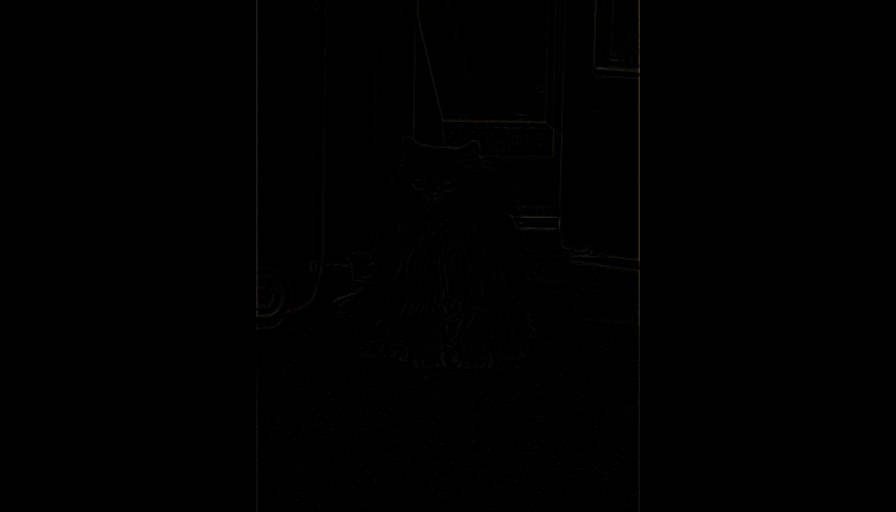

In [41]:
GAUSSIAN_KERNEL = 1/16 * np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])

LAPLACIAN_KERNEL = 1/2 * np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])



def display_np(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    display(img)

def apply_kernel(image, kernel):
    if len(image.shape) == 2:  # Grayscale image
        convolved_array = convolve2d(
            image,
            kernel,
            mode="same",
            boundary="symm"
        )
        return np.clip(convolved_array, 0, 255)
    
    elif len(image.shape) == 3:  # Color image
        convolved_array = np.zeros_like(image, dtype=np.float64)
        for channel in range(image.shape[2]):  # Iterate over color channels
            convolved_array[:, :, channel] = convolve2d(
                image[:, :, channel],
                kernel,
                mode="same",
                boundary="symm"
            )
        return np.clip(convolved_array, 0, 255)

def gaussian_pyramid(image, levels):
    gaussians = [image]  # Level 0 is the original image
    for i in range(levels):
        image = cv2.pyrDown(image)  # Reduce size and apply Gaussian blur
        gaussians.append(image)
    return gaussians

def laplacian_pyramid(image, levels):
    gaussians = gaussian_pyramid(image, levels)
    laplacians = []
    for i in range(levels):
        gaussian_expanded = cv2.pyrUp(gaussians[i + 1], dstsize=(gaussians[i].shape[1], gaussians[i].shape[0]))
        laplacian = cv2.subtract(gaussians[i], gaussian_expanded)
        laplacians.append(laplacian)
    laplacians.append(gaussians[-1])  # The last Gaussian level is kept
    return laplacians


img = Image.open("./Grumpy.jpg").convert("RGB")

g0 = np.array(img)




def reconstruct_from_laplacian(laplacians):
    reconstructed = laplacians[-1]  # Start from the smallest Gaussian
    for i in range(len(laplacians) - 2, -1, -1):
        # Upsample and add the next Laplacian level
        reconstructed = cv2.pyrUp(reconstructed, dstsize=(laplacians[i].shape[1], laplacians[i].shape[0]))
        reconstructed = cv2.add(reconstructed, laplacians[i])
    return reconstructed


display_np(laplacian_pyramid(g0, 4)[1])


# Q1.1 Image Blending

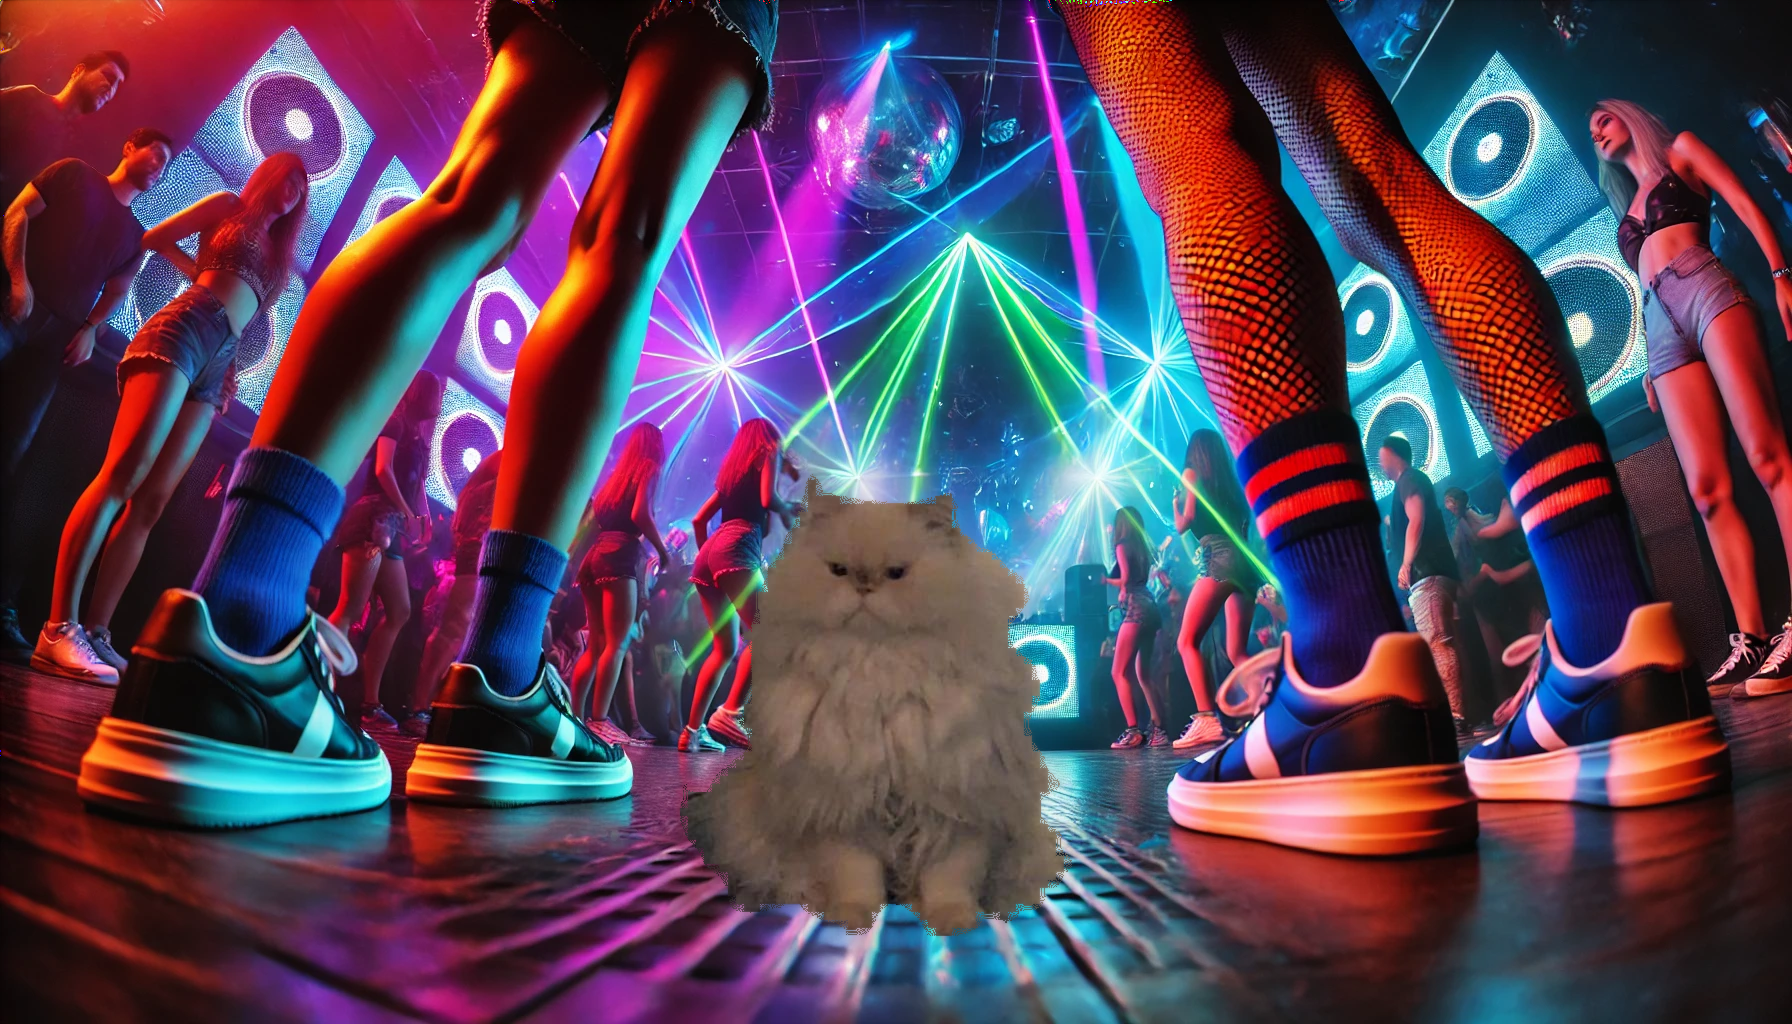

In [4]:


mask = Image.open("./GrumpyMaskDown.jpg").convert("L")
a = Image.open("./GrumpyDown.jpg")
b = Image.open("./Nightclub.webp")




mask_np = np.array(mask).astype(np.float64)
mask_np = np.where(mask_np > 0, 255, 0).astype(np.float64)
mask_np /= 255 



a_np = np.array(a).astype(np.float64)
b_np = np.array(b).astype(np.float64)


G_m = gaussian_pyramid(mask_np, 8)
L_a = laplacian_pyramid(a_np, 8)
L_b = laplacian_pyramid(b_np, 8)



L_c = []
for i in range(len(L_b)):
    Gi = G_m[i][..., np.newaxis]
    temp = ((1 - Gi) * L_a[i]) + (Gi * L_b[i])
    # temp = L_b[i]
    L_c.append(temp)



blended_img = np.copy(L_c[-1]).astype(np.float64)
for i in range(len(L_c) - 1, 0, -1):
    upsample = np.zeros((blended_img.shape[0] * 2, blended_img.shape[1]*2, blended_img.shape[2]), dtype=blended_img.dtype)
    upsample[::2,::2] = blended_img
    upsample = apply_kernel(upsample, LAPLACIAN_KERNEL)
    blended_img = upsample + L_c[i-1]




display_np(blended_img)




# Q1.2 Hybrid Images

In [5]:

def upscale(image, n):
    if n == 0:
        return image
    for _ in range(n):
        upsample = np.zeros((image.shape[0] * 2, image.shape[1] * 2, image.shape[2]), dtype=image.dtype)
        upsample[::2, ::2] = image
        upsample = apply_kernel(upsample, gaussian_kernel*3)
    return upsample



einstein = Image.open("einstein.jpeg").convert("RGB")
marylin = Image.open("marylin.jpeg").convert("RGB")

# einstein = einstein.resize((260, 200))

einstein_np = np.array(einstein)
marylin_np = np.array(marylin)  



G_einstein = laplacian_pyramid(einstein_np, 2)

for i , img in enumerate(G_einstein):
    # img = upscale(img, i)
    display(Image.fromarray(img))

ValueError: operands could not be broadcast together with shapes (130,97,3) (130,98,3) 